# Business Understanding

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The MLP-GRU model offers small businesses an advanced solution for protecting their operations against cyber threats like malware. By analyzing network traffic patterns and behaviors, it identifies and prevents malicious software from disrupting operations, even if the malware is new or sophisticated. This proactive approach minimizes the risk of data breaches, financial loss, and downtime, which can be especially damaging for small businesses. Implementing such a system enhances customer trust, ensures regulatory compliance, and safeguards business continuity, making it a valuable investment for long-term growth and security in an increasingly digital landscape.

# Data Understanding

The dataset used for the MLP-GRU model comprises network flow characteristics, including features such as protocol type, packet size, flow duration, and TCP flags. These features capture both static and sequential aspects of network activity, which are critical for identifying malware behaviors. The dataset contains labels that classify each flow as either benign or malicious, enabling the model to learn patterns associated with different types of traffic. It also includes temporal features like flow inter-arrival times and packet rates, allowing the GRU component to analyze sequential dependencies. Understanding this data is essential for building a robust malware detection system capable of identifying both known and emerging threats.

In [2]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from collections import Counter
from keras.models import Model
from keras.layers import Input, Dense, Dropout, GRU, Concatenate
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

# Data Preparation

In [6]:
df = pd.read_csv("/content/drive/MyDrive/Mlp and Gru/subset_dataset.csv")

In [7]:
df

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Flow IAT Mean,Bwd IAT Mean,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,...,SYN Flag Count,RST Flag Count,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Init_Win_bytes_forward,Init_Win_bytes_backward,Label,category
0,6.0,984922.0,3.0,2.0,2.462305e+05,40.0,96.0,64.0,3.045926,2.030618,...,1.0,0.0,114.400000,94.666667,2.0,3.0,1431.0,35.0,ADWARE_DOWGIN,AdwareMalware
1,6.0,985932.0,3.0,1.0,3.286440e+05,0.0,96.0,32.0,3.042806,1.014269,...,1.0,0.0,3.750000,1.666667,5.0,3.0,1386.0,9.0,ADWARE_DOWGIN,AdwareMalware
2,6.0,22538.0,1.0,2.0,1.126900e+04,253.0,32.0,64.0,44.369509,88.739019,...,0.0,0.0,10.333333,0.000000,15.5,1.0,2093.0,972.0,ADWARE_DOWGIN,AdwareMalware
3,6.0,31977.0,1.0,2.0,1.598850e+04,21.0,32.0,64.0,31.272477,62.544954,...,0.0,0.0,10.333333,0.000000,15.5,1.0,1641.0,972.0,ADWARE_DOWGIN,AdwareMalware
4,6.0,49401.0,1.0,1.0,4.940100e+04,0.0,32.0,32.0,20.242505,20.242505,...,0.0,0.0,0.000000,0.000000,0.0,1.0,1550.0,510.0,ADWARE_DOWGIN,AdwareMalware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576134,17.0,31241.0,1.0,1.0,3.124100e+04,0.0,20.0,32.0,32.009219,32.009219,...,0.0,0.0,112.500000,42.000000,141.0,1.0,-1.0,-1.0,SMSMALWARE_ZSONE,SmsMalware
2576135,17.0,198548.0,6.0,6.0,1.804982e+04,29245.8,188.0,224.0,30.219393,30.219393,...,0.0,0.0,804.916667,531.333333,853.5,6.0,-1.0,-1.0,SMSMALWARE_ZSONE,SmsMalware
2576136,17.0,1394.0,1.0,1.0,1.394000e+03,0.0,32.0,32.0,717.360115,717.360115,...,0.0,0.0,171.000000,48.000000,246.0,1.0,-1.0,-1.0,SMSMALWARE_ZSONE,SmsMalware
2576137,17.0,80848.0,1.0,1.0,8.084800e+04,0.0,32.0,32.0,12.368890,12.368890,...,0.0,0.0,87.000000,39.000000,96.0,1.0,-1.0,-1.0,SMSMALWARE_ZSONE,SmsMalware


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2576139 entries, 0 to 2576138
Data columns (total 22 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0    Protocol                 float64
 1    Flow Duration            float64
 2    Total Fwd Packets        float64
 3    Total Backward Packets   float64
 4    Flow IAT Mean            float64
 5    Bwd IAT Mean             float64
 6    Fwd Header Length        float64
 7    Bwd Header Length        float64
 8   Fwd Packets/s             float64
 9    Bwd Packets/s            float64
 10   Packet Length Variance   float64
 11  FIN Flag Count            float64
 12   SYN Flag Count           float64
 13   RST Flag Count           float64
 14   Average Packet Size      float64
 15   Avg Fwd Segment Size     float64
 16   Avg Bwd Segment Size     float64
 17  Subflow Fwd Packets       float64
 18  Init_Win_bytes_forward    float64
 19   Init_Win_bytes_backward  float64
 20   Label                  

In [9]:
df.columns = df.columns.str.strip()

In [10]:
df['Label'].nunique()

43

In [11]:
df['category'].nunique()

5

In [12]:
df["category"].value_counts()

,count
category,
Benign,1205515
AdwareMalware,424147
ScarewareMalware,375427
RansomewareMalware,348943
SmsMalware,222107


In [13]:
df.sample(10)

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Flow IAT Mean,Bwd IAT Mean,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,...,SYN Flag Count,RST Flag Count,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Init_Win_bytes_forward,Init_Win_bytes_backward,Label,category
409949,6.0,10642607.0,4.0,4.0,1.520372e+06,3.460826e+06,136.0,136.0,0.375848,0.375848,...,0.0,0.0,233.500000,112.0,355.000000,4.0,65535.0,122.0,ADWARE_YOUMI,AdwareMalware
233381,6.0,8696.0,1.0,1.0,8.696000e+03,0.000000e+00,32.0,32.0,114.995400,114.995400,...,0.0,0.0,0.000000,0.0,0.000000,1.0,80.0,1505.0,ADWARE_GOOLIGAN,AdwareMalware
68244,6.0,30054922.0,5.0,5.0,3.339436e+06,7.507766e+06,120.0,112.0,0.166362,0.166362,...,0.0,0.0,208.900000,113.8,304.000000,5.0,65535.0,123.0,ADWARE_EWIND,AdwareMalware
407111,6.0,502206.0,10.0,13.0,2.282755e+04,3.519792e+04,340.0,424.0,19.912148,25.885792,...,0.0,0.0,533.565217,192.3,796.076923,10.0,65535.0,374.0,ADWARE_YOUMI,AdwareMalware
2360384,6.0,9.0,2.0,0.0,9.000000e+00,0.000000e+00,64.0,0.0,222222.222222,0.000000,...,1.0,0.0,55.000000,27.5,0.000000,2.0,340.0,-1.0,SMSMALWARE_BEANBOT,SmsMalware
911735,17.0,1540.0,1.0,1.0,1.540000e+03,0.000000e+00,32.0,32.0,649.350649,649.350649,...,0.0,0.0,74.000000,37.0,74.000000,1.0,-1.0,-1.0,BENIGN,Benign
550186,6.0,489211.0,2.0,0.0,4.892110e+05,0.000000e+00,64.0,0.0,4.088216,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,2.0,1436.0,-1.0,BENIGN,Benign
1539222,6.0,4756824.0,2.0,0.0,4.756824e+06,0.000000e+00,40.0,0.0,0.420449,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,2.0,1502.0,-1.0,BENIGN,Benign
1443520,6.0,1638560.0,2.0,0.0,1.638560e+06,0.000000e+00,40.0,0.0,1.220584,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,2.0,1872.0,-1.0,BENIGN,Benign
644072,6.0,23118.0,1.0,1.0,2.311800e+04,0.000000e+00,32.0,32.0,43.256337,43.256337,...,0.0,0.0,0.000000,0.0,0.000000,1.0,1486.0,1818.0,BENIGN,Benign


In [14]:
df['RST Flag Count'].nunique()

2

In [15]:
df.isnull().sum()

,0
Protocol,0
Flow Duration,0
Total Fwd Packets,0
Total Backward Packets,0
Flow IAT Mean,1
Bwd IAT Mean,2
Fwd Header Length,3
Bwd Header Length,3
Fwd Packets/s,3
Bwd Packets/s,4


In [16]:
df = df.dropna()

In [17]:
df = df.drop_duplicates()

In [18]:
label_encoder = LabelEncoder()

df['Label_encoded'] = label_encoder.fit_transform(df['Label'])

df['category_encoded'] = label_encoder.fit_transform(df['category'])

df = df.drop(columns=['Label', 'category'])

In [19]:
df

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Flow IAT Mean,Bwd IAT Mean,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,...,SYN Flag Count,RST Flag Count,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Init_Win_bytes_forward,Init_Win_bytes_backward,Label_encoded,category_encoded
0,6.0,984922.0,3.0,2.0,2.462305e+05,40.0,96.0,64.0,3.045926,2.030618,...,1.0,0.0,114.400000,94.666667,2.0,3.0,1431.0,35.0,0,0
1,6.0,985932.0,3.0,1.0,3.286440e+05,0.0,96.0,32.0,3.042806,1.014269,...,1.0,0.0,3.750000,1.666667,5.0,3.0,1386.0,9.0,0,0
2,6.0,22538.0,1.0,2.0,1.126900e+04,253.0,32.0,64.0,44.369509,88.739019,...,0.0,0.0,10.333333,0.000000,15.5,1.0,2093.0,972.0,0,0
3,6.0,31977.0,1.0,2.0,1.598850e+04,21.0,32.0,64.0,31.272477,62.544954,...,0.0,0.0,10.333333,0.000000,15.5,1.0,1641.0,972.0,0,0
4,6.0,49401.0,1.0,1.0,4.940100e+04,0.0,32.0,32.0,20.242505,20.242505,...,0.0,0.0,0.000000,0.000000,0.0,1.0,1550.0,510.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576134,17.0,31241.0,1.0,1.0,3.124100e+04,0.0,20.0,32.0,32.009219,32.009219,...,0.0,0.0,112.500000,42.000000,141.0,1.0,-1.0,-1.0,42,4
2576135,17.0,198548.0,6.0,6.0,1.804982e+04,29245.8,188.0,224.0,30.219393,30.219393,...,0.0,0.0,804.916667,531.333333,853.5,6.0,-1.0,-1.0,42,4
2576136,17.0,1394.0,1.0,1.0,1.394000e+03,0.0,32.0,32.0,717.360115,717.360115,...,0.0,0.0,171.000000,48.000000,246.0,1.0,-1.0,-1.0,42,4
2576137,17.0,80848.0,1.0,1.0,8.084800e+04,0.0,32.0,32.0,12.368890,12.368890,...,0.0,0.0,87.000000,39.000000,96.0,1.0,-1.0,-1.0,42,4


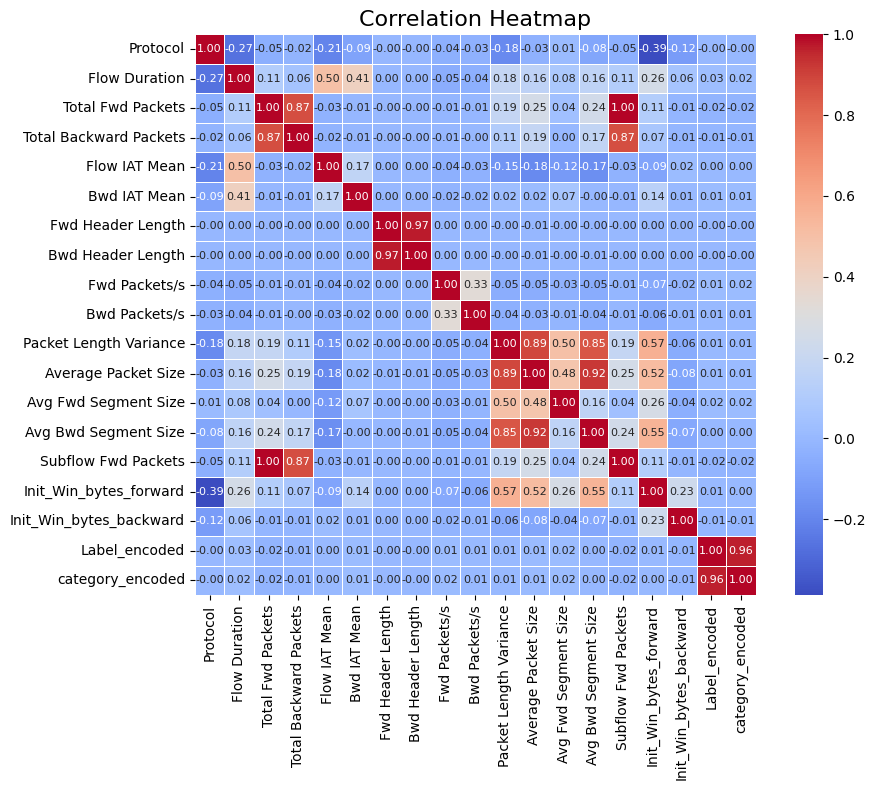

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

excluded_columns = ['SYN Flag Count', 'RST Flag Count', 'FIN Flag Count']
correlation_matrix = df.drop(columns=excluded_columns).corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.5,
    annot_kws={"size": 8}
)

plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

## Handling Outliers

### Z-Score Outlier Removal

In [22]:
numeric_df = df.select_dtypes(include=[np.number])

z_scores = np.abs(stats.zscore(numeric_df))

threshold = 3

outliers = (z_scores > threshold)

outlier_rows = np.any(outliers, axis=1)

df = df[~outlier_rows]

df.reset_index(drop=True, inplace=True)

In [23]:
df.sample(10)

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Flow IAT Mean,Bwd IAT Mean,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,...,SYN Flag Count,RST Flag Count,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Init_Win_bytes_forward,Init_Win_bytes_backward,Label_encoded,category_encoded
1141657,17.0,31610.0,1.0,1.0,3.161000e+04,0.0,40.0,40.0,31.635558,31.635558,...,0.0,0.0,80.000000,40.000000,80.000000,1.0,-1.0,-1.0,10,1
1851532,6.0,9836435.0,12.0,11.0,4.471107e+05,964493.7,392.0,360.0,1.219954,1.118291,...,0.0,0.0,307.173913,143.333333,485.909091,12.0,65535.0,37.0,35,4
7742,6.0,276690.0,2.0,1.0,1.383450e+05,0.0,40.0,20.0,7.228306,3.614153,...,0.0,0.0,0.000000,0.000000,0.000000,2.0,32.0,32.0,0,0
1419315,6.0,13897794.0,3.0,0.0,6.948897e+06,0.0,96.0,0.0,0.215862,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,3.0,1386.0,-1.0,18,2
1549152,17.0,48825.0,1.0,1.0,4.882500e+04,0.0,40.0,20.0,20.481311,20.481311,...,0.0,0.0,111.500000,34.000000,155.000000,1.0,-1.0,-1.0,24,3
366922,6.0,1837.0,1.0,1.0,1.837000e+03,0.0,20.0,20.0,544.365814,544.365814,...,0.0,0.0,0.000000,0.000000,0.000000,1.0,502.0,1369.0,10,1
1528124,6.0,2882586.0,5.0,3.0,4.117980e+05,300020.5,148.0,60.0,1.734554,1.040732,...,0.0,0.0,1.125000,0.000000,3.000000,5.0,1552.0,35.0,24,3
764251,6.0,41810006.0,3.0,0.0,2.090500e+07,0.0,60.0,0.0,0.071753,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,3.0,2404.0,-1.0,10,1
781349,17.0,133855.0,1.0,1.0,1.338550e+05,0.0,32.0,32.0,7.470771,7.470771,...,0.0,0.0,171.000000,48.000000,246.000000,1.0,-1.0,-1.0,10,1
637138,6.0,513311.0,3.0,3.0,1.026622e+05,129807.5,80.0,72.0,5.844410,5.844410,...,0.0,0.0,161.833333,218.000000,105.666667,3.0,65535.0,125.0,10,1


Class Distribution (Ascending):
category_encoded
4    171035
2    272452
3    291837
0    327673
1    919708
Name: count, dtype: int64


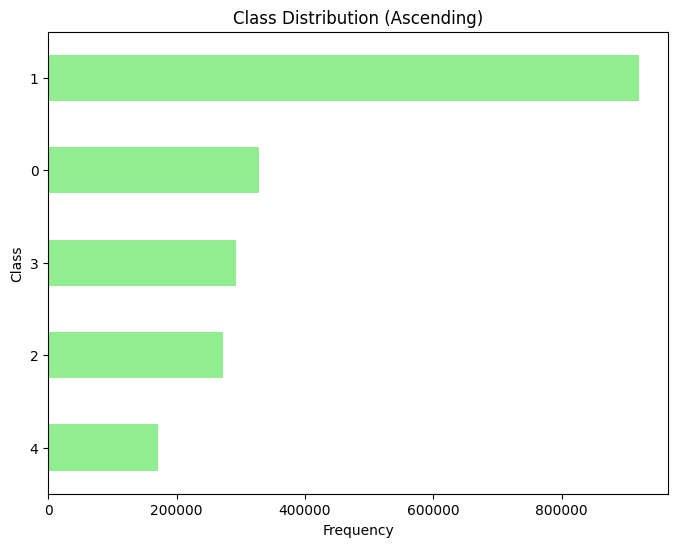

In [24]:
class_distribution = df['category_encoded'].value_counts()

# Sort the class counts in ascending order
class_distribution = class_distribution.sort_values(ascending=True)

# Print the sorted class counts
print("Class Distribution (Ascending):")
print(class_distribution)

# Plot the class distribution as a horizontal bar graph
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='barh', color='lightgreen')  # Change the color to 'lightgreen'
plt.title("Class Distribution (Ascending)")
plt.xlabel("Frequency")
plt.ylabel("Class")
plt.show()


## Feature Scaling:

## Balance the dataset:

In [25]:
import pandas as pd

# Assuming your dataset is named 'df'
# Replace 'category_encoded' with your actual column name
target_count = 272452

# Downsample categories 1, 0, and 3
df_1 = df[df['category_encoded'] == 1].sample(target_count, random_state=42)
df_0 = df[df['category_encoded'] == 0].sample(target_count, random_state=42)
df_3 = df[df['category_encoded'] == 3].sample(target_count, random_state=42)

# Keep categories 2 and 4 as is
df_2 = df[df['category_encoded'] == 2]
df_4 = df[df['category_encoded'] == 4]

# Combine all the balanced subsets
df_balanced = pd.concat([df_1, df_0, df_3, df_2, df_4])

# Shuffle the final dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['category_encoded'].value_counts())

category_encoded
2    272452
0    272452
3    272452
1    272452
4    171035
Name: count, dtype: int64


In [26]:
# Separate features (X) and target (y)
X = df_balanced.drop(columns=['category_encoded'])
y = df_balanced['category_encoded']

# Apply SMOTE only on category 4
# Convert other categories to a single majority class
smote = SMOTE(sampling_strategy={4: 272452}, random_state=42)

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine the resampled data into a new DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['category_encoded'])], axis=1)

# Check the new class distribution
print(df_resampled['category_encoded'].value_counts())

category_encoded
2    272452
4    272452
0    272452
3    272452
1    272452
Name: count, dtype: int64


### Class Distribution after SMOTE:

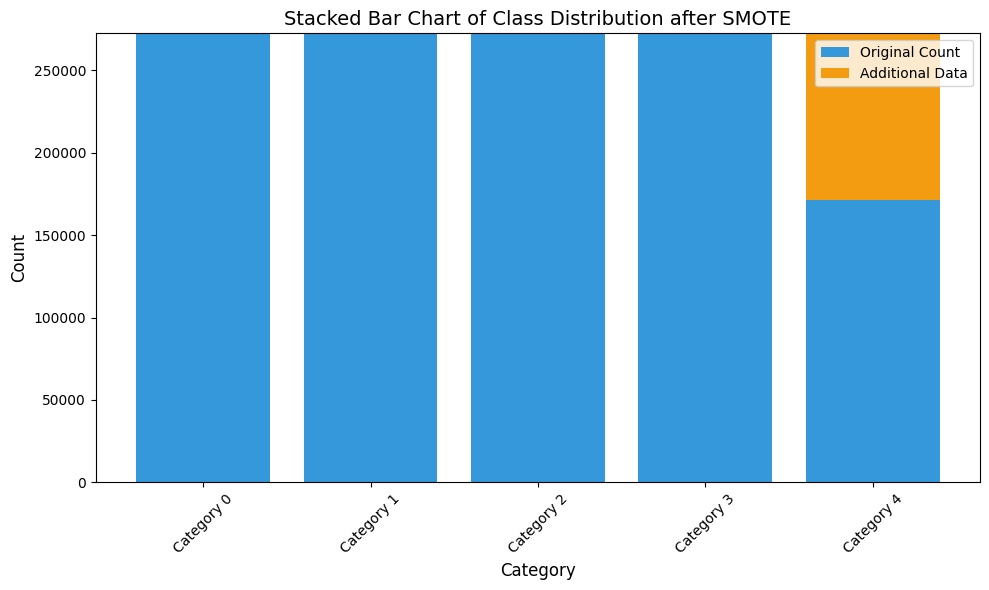

In [37]:
import numpy as np

# Create a stacked bar chart with made-up data for comparison
categories = ["Category 0", "Category 1", "Category 2", "Category 3", "Category 4"]
counts = [272452, 272452, 272452, 272452, 171035]
additional_data = [0, 0, 0, 0, 101417]  # Example: Some other data stacked over the original counts

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, label='Original Count', color='#3498db')
plt.bar(categories, additional_data, bottom=counts, label='Additional Data', color='#f39c12')

plt.title("Stacked Bar Chart of Class Distribution after SMOTE", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

### Standard Scalar

In [27]:
scaler = StandardScaler()

# Scale the resampled feature data
X_scaled = scaler.fit_transform(X_resampled)

# Combine the scaled features with the target variable
df_scaled = pd.concat([pd.DataFrame(X_scaled, columns=X.columns), pd.DataFrame(y_resampled, columns=['category_encoded'])], axis=1)

# Check the scaled DataFrame
print(df_scaled.head())

# Check the class distribution to ensure it's still balanced
print(df_scaled['category_encoded'].value_counts())

   Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0 -0.597610      -0.489173          -0.181584                0.183778   
1 -0.597610       3.057139          -0.181584               -0.435863   
2  1.670007      -0.488592          -0.498434               -0.311935   
3 -0.597610      -0.491863           0.135265                0.059850   
4 -0.597610      -0.504170          -0.498434               -0.311935   

   Flow IAT Mean  Bwd IAT Mean  Fwd Header Length  Bwd Header Length  \
0      -0.445546     -0.262693          -0.002001          -0.004622   
1       5.516584     -0.277625          -0.002008          -0.004813   
2      -0.400078     -0.277625          -0.002058          -0.004776   
3      -0.447579     -0.261710          -0.001989          -0.004708   
4      -0.452301     -0.277625          -0.002058          -0.004776   

   Fwd Packets/s  Bwd Packets/s  ...  SYN Flag Count  RST Flag Count  \
0      -0.128453      -0.088486  ...             0.0    

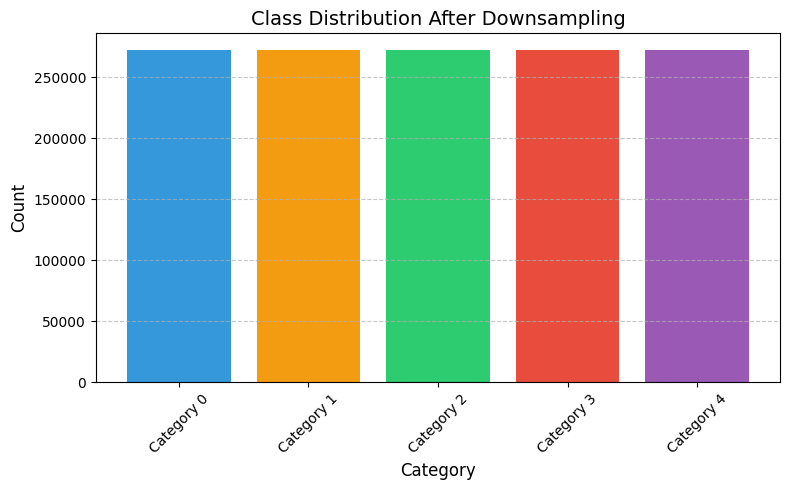

In [36]:
target_counts = {
    "Category 0": 272452,
    "Category 1": 272452,
    "Category 2": 272452,
    "Category 3": 272452,
    "Category 4": 272452,
}

# Plotting the bar chart
categories = list(target_counts.keys())
counts = list(target_counts.values())

plt.figure(figsize=(8, 5))
plt.bar(categories, counts, color=['#3498db', '#f39c12', '#2ecc71', '#e74c3c', '#9b59b6'])  # Updated colors

plt.title("Class Distribution After Downsampling", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Step 5: Split the resampled data into training and testing sets
X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

modell = RandomForestClassifier(n_estimators=100, random_state=42)
modell.fit(X_train_resampled, y_train_resampled)

# Step 6: Reshape data for GRU (time-series format)
X_train_gru = np.reshape(X_train_resampled, (X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))
X_test_gru = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Step 7: One-hot encode the target labels for multi-class classification
num_classes = len(np.unique(y_resampled))  # Automatically determine the number of classes
y_train_categorical = to_categorical(y_train_resampled, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Step 8: Define the MLP model
mlp_input = Input(shape=(X_train_resampled.shape[1],))  # MLP uses 2D input (samples, features)
mlp_layer1 = Dense(64, activation='relu')(mlp_input)  # Increased complexity for MLP
mlp_dropout1 = Dropout(0.5)(mlp_layer1)
mlp_output = Dense(32, activation='relu')(mlp_dropout1)

# Step 9: Define the GRU model
gru_input = Input(shape=(X_train_gru.shape[1], X_train_gru.shape[2]))  # GRU uses 3D input (samples, timesteps, features)
gru_layer1 = GRU(64, return_sequences=False, activation='relu')(gru_input)  # Increased complexity for GRU
gru_dropout1 = Dropout(0.5)(gru_layer1)

# Step 10: Concatenate the outputs of MLP and GRU
merged = Concatenate()([mlp_output, gru_dropout1])

# Step 11: Output layer for multi-class classification
output = Dense(num_classes, activation='softmax')(merged)

# Step 12: Create the hybrid MLP + GRU model
model = Model(inputs=[mlp_input, gru_input], outputs=output)

# Step 13: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 14: Train the model
history = model.fit(
    [X_train_resampled, X_train_gru],  # Inputs: MLP and GRU
    y_train_categorical,  # Target labels
    epochs=10,  # Adjust epochs as needed
    batch_size=32,  # Adjust batch size as needed
    validation_data=([X_test, X_test_gru], y_test_categorical),  # Validation data
    verbose=1
)

# Step 15: Evaluate the model
loss, accuracy = model.evaluate([X_test, X_test_gru], y_test_categorical, verbose=0)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/10
34057/34057 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - accuracy: 0.9224 - loss: 0.2365 - val_accuracy: 0.9909 - val_loss: 0.0410
Epoch 2/10
34057/34057 ━━━━━━━━━━━━━━━━━━━━ 85s 2ms/step - accuracy: 0.9847 - loss: 0.0599 - val_accuracy: 0.9923 - val_loss: 0.0354
Epoch 3/10
34057/34057 ━━━━━━━━━━━━━━━━━━━━ 158s 3ms/step - accuracy: 0.9880 - loss: 0.0507 - val_accuracy: 0.9923 - val_loss: 0.0360
Epoch 4/10
34057/34057 ━━━━━━━━━━━━━━━━━━━━ 131s 3ms/step - accuracy: 0.9895 - loss: 0.0475 - val_accuracy: 0.9933 - val_loss: 0.0344
Epoch 5/10
34057/34057 ━━━━━━━━━━━━━━━━━━━━ 85s 2ms/step - accuracy: 0.9905 - loss: 0.0480 - val_accuracy: 0.9930 - val_loss: 0.0334
Epoch 6/10
34057/34057 ━━━━━━━━━━━━━━━━━━━━ 142s 2ms/step - accuracy: 0.9913 - loss: 0.0434 - val_accuracy: 0.9944 - val_loss: 0.0302
Epoch 7/10
34057/34057 ━━━━━━━━━━━━━━━━━━━━ 142s 3ms/step - accuracy: 0.9916 - loss: 0.0419 - val_accuracy: 0.9933 - val_loss: 0.0346
Epoch 8/10
34057/34057 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step - accura

## Model accuracy And Model loss

Test Loss: 0.032147977501153946
Test Accuracy: 0.994263231754303


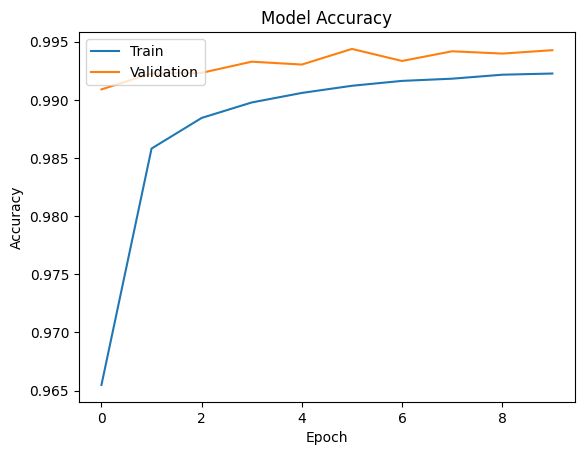

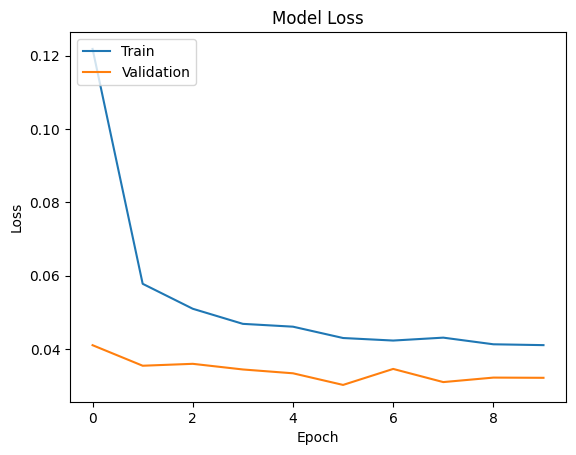

In [ ]:
# Step 14: Evaluate the model on the test data
loss, accuracy = model.evaluate([X_test, X_test_gru], y_test_categorical, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Step 15: Plot the training history
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict([X_test, X_test_gru])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix as a diagram without colorbar
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
fig, ax = plt.subplots()
disp.plot(cmap='Blues', values_format='d', ax=ax, colorbar=False)
plt.title("Confusion Matrix")
plt.show()

## Classification Report

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54312
           1       0.99      1.00      0.99     54415
           2       1.00      1.00      1.00     54615
           3       0.99      0.99      0.99     54605
           4       1.00      0.99      0.99     54505

    accuracy                           0.99    272452
   macro avg       0.99      0.99      0.99    272452
weighted avg       0.99      0.99      0.99    272452



## ROC-AUC Curve (for Multi-Class)

8515/8515 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step


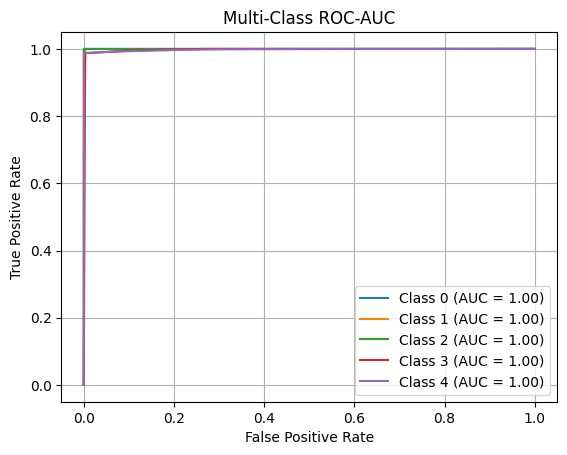

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC calculation
y_test_bin = label_binarize(y_true, classes=np.unique(y_true))
y_pred_prob = model.predict([X_test, X_test_gru])

# Compute ROC curve and AUC for each class
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.title("Multi-Class ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Actual vs Predicted Congestion Labels for Sample Test Data

In [ ]:
# Reset index of y_test for consistency
y_test_reset_index = y_test.reset_index(drop=True)

# Take the first 20 values from the test set
X_sample = X_test[5:25]  # Sample from the test set
y_actual = y_test_reset_index[5:25]

# Reshape the X_sample for both MLP and GRU inputs
X_sample_gru = np.reshape(X_sample, (X_sample.shape[0], 1, X_sample.shape[1]))

# Predict congestion labels for the sampled data using both MLP and GRU
y_pred_prob_sample = model.predict([X_sample, X_sample_gru])  # Use MLP and GRU inputs together
y_pred_sample = np.argmax(y_pred_prob_sample, axis=1)  # Get predicted classes

# Print actual vs predicted labels for the sample
print("Actual vs Predicted Congestion Labels:")
for i in range(20):
    print(f"Actual: {y_actual.iloc[i]}, Predicted: {y_pred_sample[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
Actual vs Predicted Congestion Labels:
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 3, Predicted: 3
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 3, Predicted: 3
Actual: 1, Predicted: 1
Actual: 4, Predicted: 4
Actual: 2, Predicted: 2
Actual: 2, Predicted: 2
Actual: 2, Predicted: 2
Actual: 1, Predicted: 1


8515/8515 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step


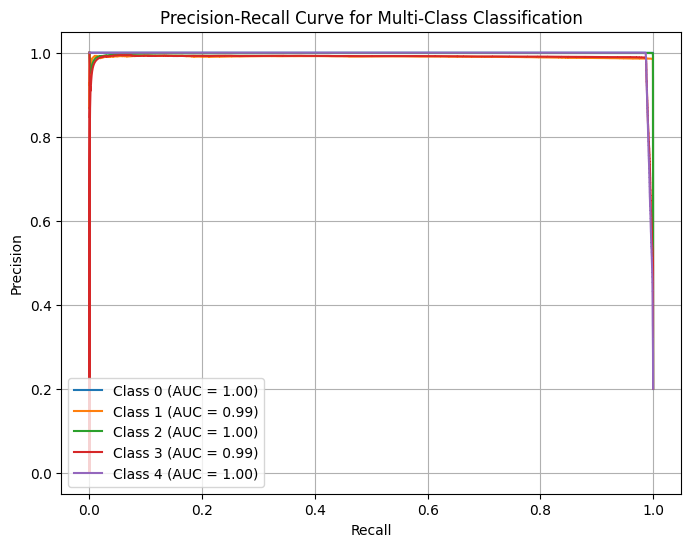

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels for Precision-Recall calculation
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

# Predict probabilities for each class
y_pred_prob = model.predict([X_test, X_test_gru])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(y_true_bin.shape[1]):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    pr_auc = auc(recall, precision)  # Compute AUC for the Precision-Recall curve
    plt.plot(recall, precision, label=f"Class {i} (AUC = {pr_auc:.2f})")

# Add title and labels
plt.title("Precision-Recall Curve for Multi-Class Classification")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

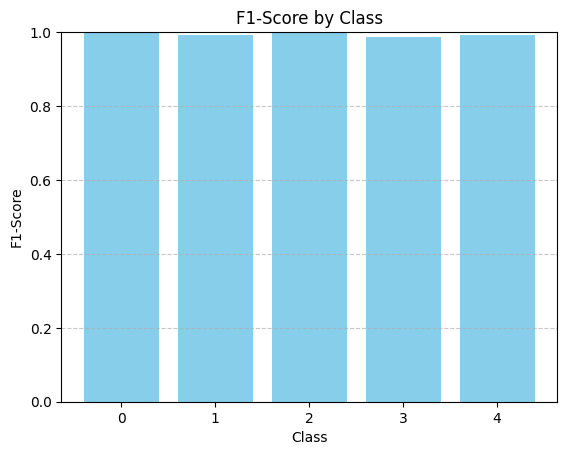

In [ ]:
from sklearn.metrics import f1_score

f1_scores = f1_score(y_true, y_pred_classes, average=None)
plt.bar(range(len(f1_scores)), f1_scores, color='skyblue')
plt.title('F1-Score by Class')
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.xticks(range(len(f1_scores)), labels=np.unique(y_true))
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

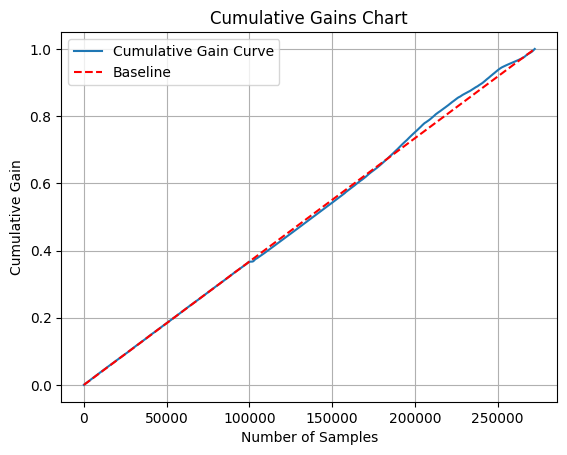

In [ ]:
from sklearn.metrics import roc_curve

sorted_indices = np.argsort(y_pred_prob.max(axis=1))[::-1]
sorted_actual = y_true[sorted_indices]

cumulative_gain = np.cumsum(sorted_actual) / np.sum(sorted_actual)
plt.plot(cumulative_gain, label='Cumulative Gain Curve')
plt.plot([0, len(cumulative_gain)], [0, 1], linestyle='--', color='red', label='Baseline')
plt.title('Cumulative Gains Chart')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Gain')
plt.legend()
plt.grid(True)
plt.show()